In [1]:
!pip install pytorch_tabnet
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
X_full = pd.read_csv('../data/concrete_preprocessed.csv')
y = (X_full['strength'])
X = X_full.drop(['strength'], axis=1)

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cement                           904 non-null    float64
 1   blast_furnace_slag               904 non-null    float64
 2   fly_ash                          904 non-null    float64
 3   water                            904 non-null    float64
 4   superplasticizer                 904 non-null    float64
 5   coarse_aggregate                 904 non-null    float64
 6   fine_aggregate                   904 non-null    float64
 7   age                              904 non-null    float64
 8   cement_to_water_ratio            904 non-null    float64
 9   fine_aggregate_to_water_ratio    904 non-null    float64
 10  coarse_aggregate_to_water_ratio  904 non-null    float64
dtypes: float64(11)
memory usage: 77.8 KB


In [4]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)

In [5]:
X_train      = X_train.to_numpy()
y_train      = y_train.to_numpy().reshape(-1,1)
X_val      = X_val.to_numpy()
y_val      = y_val.to_numpy().reshape(-1,1)
X_test      = X_test.to_numpy()
y_test      = y_test.to_numpy().reshape(-1,1)

In [6]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
predictions_array =[]
CV_score_array    =[]
for train_index, test_index in kf.split(X_train_valid):
    X_train, X_valid = X_train_valid[train_index], X_train_valid[test_index]
    y_train, y_valid = y_train_valid[train_index], y_train_valid[test_index]
    regressor = TabNetRegressor(verbose=0,seed=42)
    regressor.fit(X_train=X_train, y_train=y_train,
              eval_set=[(X_valid, y_valid)],
              patience=500, max_epochs=2500,
              eval_metric=['rmse'])
    CV_score_array.append(regressor.best_cost)
    predictions_array.append(np.expm1(regressor.predict(X_test)))

predictions = np.mean(predictions_array,axis=0)

KeyError: "None of [Index([  1,   3,   4,   5,   7,   8,  12,  13,  14,  16,\n       ...\n       525, 527, 531, 532, 533, 536, 538, 539, 540, 541],\n      dtype='int64', length=433)] are in the [columns]"

In [ ]:
print("The CV score is %.5f" % np.mean(CV_score_array,axis=0))

The CV score is 38.75957


In [ ]:
regressor.feature_importances_

array([0.03866839, 0.07269889, 0.1730206 , 0.04267524, 0.05655079,
       0.15343395, 0.09014205, 0.05561643, 0.04866863, 0.09567723,
       0.1728478 ])

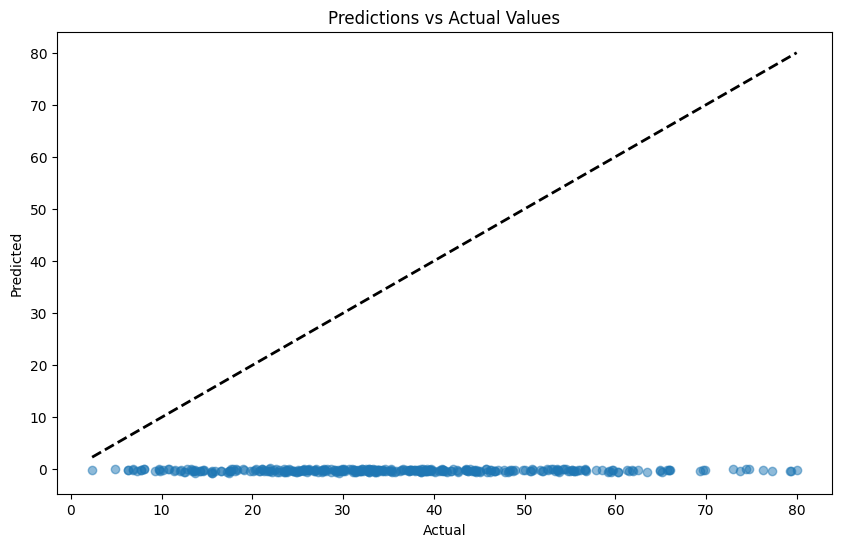

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual Values')
plt.show()